### Simulate RDD Data 

# Make some choices

Running this cell will define the variables of interest, our hyperparameters and some training options.

Make sure your Google Colab runtime has a GPU. You can turn this on via:

`Runtime -> Change Runtime type -> Hardware Accelerator -> GPU`

In [1]:
import wgan
import torch
import pandas as pd
from rdd import rdd 
import numpy as np
import importlib
importlib.reload(wgan)
#assert torch.cuda.is_available()

# T | X 

<module 'wgan' from '/Users/evanmunro/Documents/GitHub/rdd-gan/wgan.py'>

### Matsudaira data 

In [3]:
file = "data/cleaned/m_math.csv"
df = pd.read_csv(file)
df.head() 

,y,x,t
0,0.608838,30,0
1,0.924251,21,0
2,-0.884120,-43,0
3,0.293424,27,1
4,0.440617,24,0


In [4]:
dfa = df[df['x']>0].copy()#.head(1000)
print(dfa.head())

dfb = df[df['x']<=0].copy()#.head(1000)

#dfs = pd.concat([dfa,dfb],axis=0,ignore_index=True)

          y   x  t
0  0.608838  30  0
1  0.924251  21  0
3  0.293424  27  1
4  0.440617  24  0
7  2.143850  62  0


In [7]:
dc = [256,128,64]
d = [64,128,256]
penalty=10 
batch=10000

## Generate X jointly 

In [8]:
#Generate X alone 
dwx = wgan.DataWrapper(df,["x"])
x,context = dwx.preprocess(df)
specs = wgan.Specifications(dwx,batch_size=10000, max_epochs=50,
                            critic_d_hidden=[128,128,128],
                            generator_d_hidden=[64,64,64],
                            generator_d_noise=3, 
                            critic_gp_factor=penalty, 
                            optimizer='Adam',
                            generator_lr=0.0001, 
                            critic_lr = 0.0001, 
                            print_every=100)
generatorx = wgan.Generator(specs)
criticx = wgan.Critic(specs)

settings: {'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0001, 'critic_gp_factor': 10, 'generator_d_hidden': [64, 64, 64], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 3, 'gaussian_similarity_penalty': None, 'optimizer': 'Adam', 'max_epochs': 50, 'batch_size': 10000, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}


In [318]:
wgan.train(generatorx, criticx, x, context, specs)

epoch 0 | step 8 | WD_test 0.06 | WD_train 0.03 | sec passed 2 |


## Generate T|X above and below cutoff 

In [9]:
print("Training treatment indicator")
dwt = wgan.DataWrapper(df,categorical_vars=["t"],context_vars=["x"])
specs  = wgan.Specifications(dwt,
                              batch_size=batch,
                              max_epochs=1000,
                              generator_d_noise=3,
                              critic_d_hidden=dc,
                              generator_d_hidden=d,
                              critic_gp_factor=penalty, 
                              print_every=100,
                              generator_lr = 0.0005, 
                              critic_lr = 0.0005, 
                              optimizer='Adam')

xa,contexta = dwt.preprocess(dfa)
generatorta = wgan.Generator(specs)
criticta = wgan.Critic(specs)


xb,contextb = dwt.preprocess(dfb)
generatortb = wgan.Generator(specs)
critictb = wgan.Critic(specs)


Training treatment indicator
settings: {'critic_d_hidden': [256, 128, 64], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0005, 'critic_gp_factor': 10, 'generator_d_hidden': [64, 128, 256], 'generator_dropout': 0.1, 'generator_lr': 0.0005, 'generator_d_noise': 3, 'gaussian_similarity_penalty': None, 'optimizer': 'Adam', 'max_epochs': 1000, 'batch_size': 10000, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}


In [129]:
wgan.train(generatorta, criticta, xa, contexta, specs)
wgan.train(generatortb, critictb, xb, contextb, specs)

epoch 0 | step 6 | WD_test 0.14 | WD_train 0.06 | sec passed 2 |
epoch 100 | step 506 | WD_test 0.1 | WD_train 0.13 | sec passed 186 |
epoch 200 | step 1006 | WD_test 0.09 | WD_train 0.12 | sec passed 186 |
epoch 300 | step 1506 | WD_test 0.08 | WD_train 0.11 | sec passed 184 |
epoch 400 | step 2006 | WD_test 0.09 | WD_train 0.11 | sec passed 186 |
epoch 500 | step 2506 | WD_test 0.09 | WD_train 0.12 | sec passed 186 |
epoch 600 | step 3006 | WD_test 0.08 | WD_train 0.1 | sec passed 184 |
epoch 700 | step 3506 | WD_test 0.07 | WD_train 0.08 | sec passed 186 |
epoch 800 | step 4006 | WD_test 0.02 | WD_train 0.04 | sec passed 186 |
epoch 900 | step 4506 | WD_test 0.01 | WD_train 0.02 | sec passed 185 |
epoch 0 | step 4 | WD_test 0.04 | WD_train 0.01 | sec passed 1 |
epoch 100 | step 304 | WD_test 0.48 | WD_train 0.6 | sec passed 82 |
epoch 200 | step 604 | WD_test 0.39 | WD_train 0.44 | sec passed 82 |
epoch 300 | step 904 | WD_test 0.14 | WD_train 0.21 | sec passed 83 |
epoch 400 | step

## Generate Y|X above and below the cutoff 

In [98]:
#Generate Y | X, above and below cutoff 

dwya = wgan.DataWrapper(dfa,["y"],context_vars=["x"])
xa,contexta = dwya.preprocess(dfa)
specsa  = wgan.Specifications(dwya,
                              batch_size=500,
                              max_epochs=25,
                              generator_d_noise=3,
                              critic_d_hidden=dc,
                              generator_d_hidden=d,
                              critic_gp_factor=penalty,
                              print_every=100,
                              optimizer='Adam',
                              generator_lr = 0.0001, 
                              critic_lr = 0.0001) 

#above cutoff
generatorya = wgan.Generator(specsa)
criticya = wgan.Critic(specsa)

dwyb = wgan.DataWrapper(dfb,["y"],context_vars=["x"])
print(dwyb.means)
print(dwyb.stds) 
#below cutoff 
specsb  = wgan.Specifications(dwyb,
                              batch_size=5,
                              max_epochs=25,
                              generator_d_noise=3,
                              critic_d_hidden=dc,
                              generator_d_hidden=d,
                              critic_gp_factor=penalty, 
                              print_every=100,
                              generator_lr=0.0001,
                              critic_lr=0.0001, 
                              optimizer='Adam') 
xb,contextb = dwyb.preprocess(dfb)
generatoryb = wgan.Generator(specsb)
criticyb = wgan.Critic(specsb)

settings: {'critic_d_hidden': [256, 128, 64], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0001, 'critic_gp_factor': 10, 'generator_d_hidden': [64, 128, 256], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 3, 'gaussian_similarity_penalty': None, 'optimizer': 'Adam', 'max_epochs': 25, 'batch_size': 500, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cpu'}
[tensor([[-0.9493]]), tensor([[-29.1625]])]
[tensor([[0.8562]]), tensor([[35.2069]])]
settings: {'critic_d_hidden': [256, 128, 64], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.0001, 'critic_gp_factor': 10, 'generator_d_hidden': [64, 128, 256], 'generator_dropout': 0.1, 'generator_lr': 0.0001, 'generator_d_noise': 3, 'gaussian_similarity_penalty': None, 'optimizer': 'Adam', 'max_epochs': 25, 'batch_size': 5, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, '

In [94]:
wgan.train(generatoryb, criticyb, xb, contextb, specsb)
wgan.train(generatorya, criticya, xa, contexta, specsa)

epoch 0 | step 4 | WD_test 0.33 | WD_train 0.47 | sec passed 1 |
epoch 0 | step 6 | WD_test 0.08 | WD_train 0.25 | sec passed 2 |


### Generate Joint 

In [ ]:
wgan.train(generatorj, criticj, x, context, specs)

## Test Generated Data 

In [105]:
def apply_models(df): 
    s = dwx.apply_generator(generatorx,df)
    sa = s[s['x']>0]
    sb = s[s['x']<=0] 
    sa = dwya.apply_generator(generatorya,sa) 
    sb = dwyb.apply_generator(generatoryb,sb)
    sa = dwt.apply_generator(generatorta,sa)
    sb = dwt.apply_generator(generatortb,sb) 
    return pd.concat([sa,sb],axis=0,ignore_index=True)

def apply_joint(dfa,dfb):
    df = pd.concat([dfa,dfb],axis=0,ignore_index=True)
    df = dwj.apply_generator(generatorj,df) 
    return df 

def apply_below(dfb): 
    print(dwyb.means) 
    dfb = dwyb.apply_generator(generatoryb,dfb)
    return dfb 

def apply_above(dfa): 
    dfa = dwya.apply_generator(generatorya,dfa)
    return dfa 

In [208]:
dfb.shape

(21209, 3)

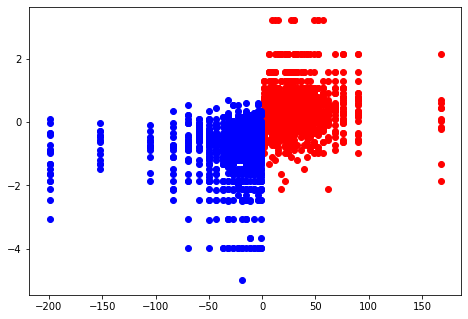

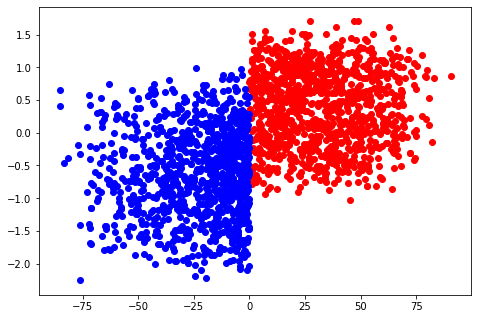

In [106]:
import matplotlib.pyplot as plt
df_fake = apply_models(df)
#df_fake = apply_joint(dfa,dfb)
df_fa = df_fake[df_fake['x']>0] 
df_fb = df_fake[df_fake['x']<=0] 
#df_fb = apply_below(dfb) 
#df_fa = apply_above(dfa) 

fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(dfa['x'].sample(1000),dfa['y'].sample(1000), color='r')
ax.scatter(dfb['x'].sample(1000),dfb['y'].sample(1000), color='b')

fig2=plt.figure() 
ax=fig2.add_axes([0,0,1,1])
ax.scatter(df_fa['x'].sample(1000),df_fa['y'].sample(1000), color='r')
ax.scatter(df_fb['x'].sample(1000),df_fb['y'].sample(1000), color='b')


In [288]:
rdd_fuzzy(df,h=5)

0.05567375608049535
-0.3717972624189916


-0.1497422431737935

In [107]:
rdd_estimate(df_fake.sample(7000))

3.0638517727738823
Estimation Equation:	 y ~ TREATED + x


-0.26431840189529554

In [109]:
rdd_estimate(df.sample(8000))

1.2437314944012584e-05
Estimation Equation:	 y ~ TREATED + x


ValueError: zero-size array to reduction operation maximum which has no identity

In [267]:
def rdd_fuzzy(data,h):
    data = data[data["x"].abs()<=h]
    da = data[data['x']>0]
    db = data[data['x']<=0]
    denom = da['y'].mean() - db['y'].mean()
    num = da['t'].mean() - db['t'].mean() 
    print(denom)
    print(num)
    est = (da['y'].mean() - db['y'].mean())/(da['t'].mean() - db['t'].mean())
    return est 

Finally, we can examine our generated data with the `compare_dfs` function.


In [30]:
def rdd_estimate(data):
    bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=0) 
    print(bandwidth_opt)
    data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=0) 
    model = rdd.rdd(data_rdd, 'x', 'y', cut=0)
    return model.fit().params[1]

In [99]:
# Option 2: load trained model parameters
def load_saved_parameters(type):
    for model, name in zip([generatorx, criticx,
                          generatorya, criticya,
                          generatoryb, criticyb, 
                          generatorta, criticta,
                          generatortb, critictb], 
                         ["Gx","Cx","Gya","Cya","Gyb","Cyb","Gta","Cta","Gtb","Ctb"]):
        state_dict = torch.load("trained_models/" + name + "_{}.pth".format(type))
        model.load_state_dict(state_dict)

load_saved_parameters("mats_math")

In [102]:
def evaluate_results():
  # Let's print the att!
  print("--------------------RDD--------------------")
  #print("real:",rdd_estimate(df)) 
  #print("fake:",rdd_estimate(df_fake))

  # Now, we'll compare our fake data to the real data
  table_groupby = ["t"]
  scatterplot = dict(x= ["x"],
                     y= ["y"],
                     samples = 5000, smooth = 1)
  histogram = dict(variables=['x','y','x','t'],
                   nrow=2, ncol=2)
  wgan.compare_dfs(df, df_fake, figsize=5, histogram=histogram, scatterplot=scatterplot)


--------------------RDD--------------------
-------------comparison of means-------------
source   fake   real
y        0.10   0.00
x       16.19  14.90
t        0.21   0.22
-------------comparison of stds-------------
source   fake   real
y        0.79   1.00
x       33.22  41.23
t        0.41   0.42


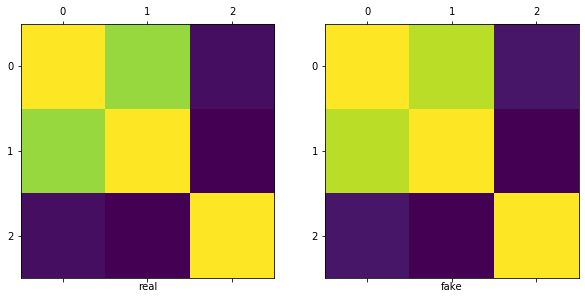

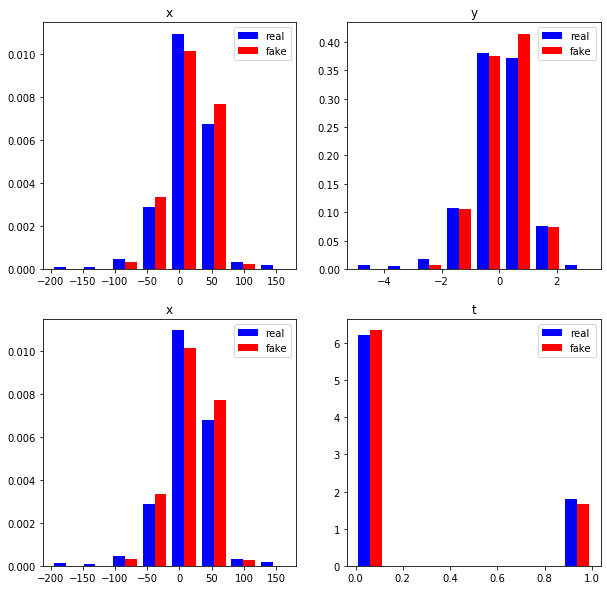

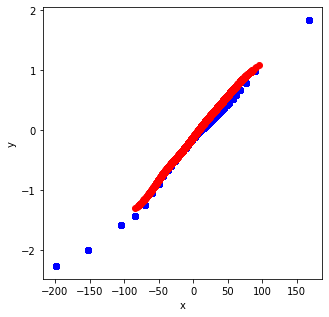

In [110]:
evaluate_results()

Looks good enough? Then save the models, generate a large dataframe and export it.

In [296]:
# save trained model parameters
def save_trained_parameters(type):
  #%mkdir trained_models
  for model, name in zip([generatorx, criticx,
                          generatorya, criticya,
                          generatoryb, criticyb, 
                          generatorta, criticta,
                          generatortb, critictb,], 
                         ["Gx","Cx","Gya","Cya","Gyb","Cyb","Gta","Cta","Gtb","Ctb"]):
    torch.save(model.state_dict(), "trained_models/" + name + "_{}.pth".format(type))

In [297]:
save_trained_parameters("mats_math")

In [112]:
# generate and save data of a certain sample size
def save_generated_data(type,n):
    s = df.sample(int(n),replace=True)
    df_fake = apply_models(s)
    df_fake.to_feather("data/generated/{}_generated.feather".format(type))

In [300]:
dfa.shape[0]

47589

In [114]:
save_generated_data("mats_math",10000000)

### Generating Figures

In [401]:
gen_data1 = df_fake[df_fake["x"]>0].copy()
real_data1 = df[df["x"]>0].copy() 

gen_data2 = df_fake[df_fake["x"]<=0].copy()
real_data2 = df[df["x"]<=0].copy() 

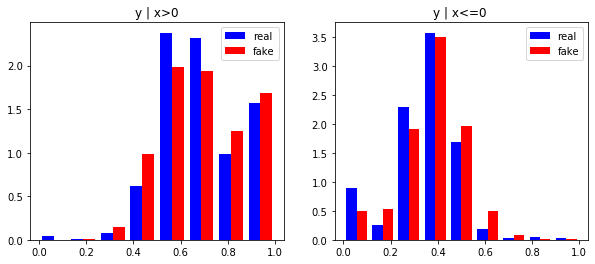

In [403]:
fig1, axarr = plt.subplots(1,2,figsize=(10, 4))
axarr[0].hist([real_data1["y"],gen_data1["y"]], bins=8, density=1,
                histtype='bar', label=["real", "fake"], color=["blue", "red"])
axarr[1].hist([real_data2["y"],gen_data2["y"]],bins=9,density=1,histtype='bar',
                  label=["real","fake"], color=["blue","red"])
axarr[0].legend(prop={"size": 10})
axarr[0].set_title("y | x>0")

axarr[1].legend(prop={"size": 10})
axarr[1].set_title("y | x<=0 ")
fig1.savefig("y_splithist.pdf")

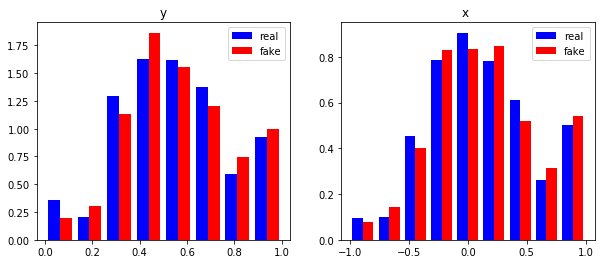

In [404]:
fig2, axarr = plt.subplots(1,2,figsize=(10, 4))
axarr[0].hist([df["y"],df_fake["y"]], bins=8, density=1,
                histtype='bar', label=["real", "fake"], color=["blue", "red"])
axarr[1].hist([df["x"],df_fake["x"]],bins=9,density=1,histtype='bar',
                  label=["real","fake"], color=["blue","red"])
axarr[0].legend(prop={"size": 10})
axarr[0].set_title("y")

axarr[1].legend(prop={"size": 10})
axarr[1].set_title("x ")
fig2.savefig("uncond_hist.pdf")

In [ ]:
fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(context2b.numpy(),x2b.numpy(), color='b')
ax.scatter(context2a.numpy(),x2a.numpy(), color='r')


fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(dfa['x'],dfa['y'], color='r')
ax.scatter(dfb['x'],dfb['y'], color='b')

u_da = data_wrapper2.deprocess(x2a,context2a)
u_db = data_wrapper2.deprocess(x2b,context2b)

fig=plt.figure() 
ax=fig.add_axes([0,0,1,1])
ax.scatter(u_da['x'],u_da['y'], color='r')
ax.scatter(u_db['x'],u_db['y'], color='b')



## Generate joint

In [ ]:
dwj = wgan.DataWrapper(dfs,["y"],context_vars=["x"])
specs  = wgan.Specifications(dwj,
                              batch_size=500,
                              max_epochs=500,
                              generator_d_noise=3,
                              critic_d_hidden=[128,128,128],
                              generator_d_hidden=[64,64,64],
                              critic_gp_factor=5, 
                              print_every=100,
                              generator_dropout=dropout)
x,context = dwj.preprocess(dfs)
generatorj = wgan.Generator(specs)
criticj = wgan.Critic(specs)